# Detecção de objetos YOLO com OpenCV e Python

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights

## Preparação da imagem

In [3]:
# read input image
image = cv2.imread('data/exemplo.jpg')
Width = image.shape[1]
Height = image.shape[0]
scale = 0.00392

In [4]:
# read class names from text file
classes = None
with open('config/yolov3.txt', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

In [5]:
# generate different colors for different classes 
COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

In [6]:
# read pre-trained model and config file
net = cv2.dnn.readNet('yolov3.weights', 'config/yolov3.cfg')

In [7]:
# create input blob 
blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

In [8]:
# set input blob for the network
net.setInput(blob)

Read the input image and get its width and height.<br>
Read the text file containing class names in human readable form and extract the class names to a list.<br>
Generate different colors for different classes to draw bounding boxes.

In [9]:
blob = cv2.dnn.blobFromImage(image, scale, (Width,Height), (0,0,0), True, crop=False)
net.setInput(blob)

## Output layer and bounding box

In [10]:
# function to get the output layer names 
# in the architecture
def get_output_layers(net):
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    return output_layers

In [11]:
# function to draw bounding box on the detected object with class name
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):
    label = f'{str(classes[class_id])}: {confidence:.2f}%'
    color = COLORS[class_id]
    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)
    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

Generally in a sequential CNN network there will be only one output layer at the end. In the YOLO v3 architecture we are using there are multiple output layers giving out predictions. get_output_layers() function gives the names of the output layers. An output layer is not connected to any next layer.<br>
draw_bounding_box() function draws rectangle over the given predicted region and writes class name over the box. If needed, we can write the confidence value too.

## Running inference

In [12]:
# run inference through the network
# and gather predictions from output layers
outs = net.forward(get_output_layers(net))

In [13]:
# initialization
class_ids = []
confidences = []
boxes = []
conf_threshold = 0.5
nms_threshold = 0.4

In [14]:
# for each detetion from each output layer 
# get the confidence, class id, bounding box params
# and ignore weak detections (confidence < 0.5)
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * Width)
            center_y = int(detection[1] * Height)
            w = int(detection[2] * Width)
            h = int(detection[3] * Height)
            x = center_x - w / 2
            y = center_y - h / 2
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([x, y, w, h])

## Non-max suppression

In [15]:
# apply non-max suppression
indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

In [16]:
# go through the detections remaining
# after nms and draw bounding box
for i in indices:
    box = boxes[i]
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    
    draw_bounding_box(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))

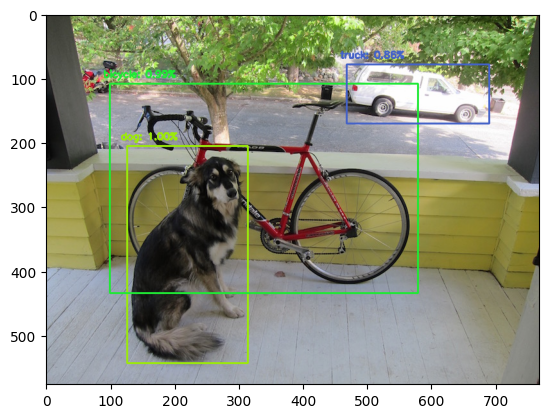

In [17]:
# display output image    
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()